# CS342 Coursework - University of Warwick
#### Shayan Borhani Yazdi - Dec 2023
Throughout this notebook we aim to implement PCA without explicitly computing matrix Z in kernel trick, and classify data using a single decision stump

-> Importing our data and printing it

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

circles = pd.read_csv('circles.data', header=None)
print(circles)

            0         1  2
0   -1.552773  0.137877  1
1    1.311324  2.914815  1
2    1.292321  0.954078  1
3    0.458968  1.461918  1
4    1.626796  1.839312  1
..        ...       ... ..
495  1.246676  3.856033  2
496  3.131496 -4.703848  2
497 -5.554466  2.886200  2
498 -5.806424 -1.677074  2
499 -8.551765 -1.518414  2

[500 rows x 3 columns]


Plotting the raw data points

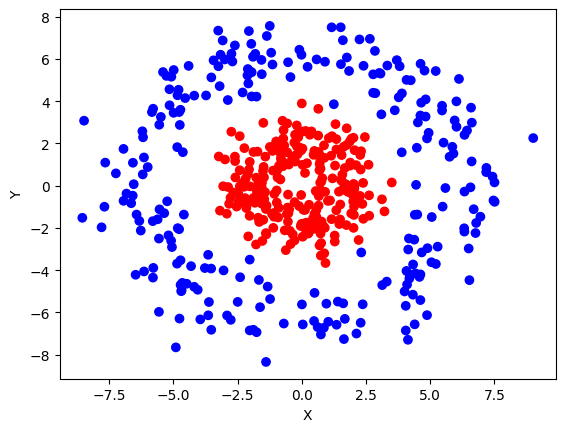

In [3]:
x = circles.iloc[:, 0]
y = circles.iloc[:, 1]

plt.scatter(x, y, c=circles.iloc[:, 2].map({1: 'red', 2: 'blue'}))

plt.xlabel('X')
plt.ylabel('Y')


plt.show()

Given a kernel function and the entry data, we need a function that will build the matrix K, and centers it using the equation 8

In [4]:
def center_K(Ker, n):
    row_averages = []
    for i in range(n):
        sum = 0
        for j in range(n):
            sum += Ker[i][j]
        row_averages.append(sum/n)
    total_average = np.sum(Ker)/(n*n)
    K_centered = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            K_centered[i][j] = Ker[i][j] - row_averages[i] - row_averages[j] + total_average
    return K_centered

In [5]:
#function to compute our matrix K based on a given kernel function:
#X is our data, kernel is the function defined based on our choice
def Matrix_K(X, kernel):
    n = len(X) #rows
    Ker = np.empty((n,n))

    for i in range(n):
        for j in range(i,n):
            val = kernel(X.iloc[i, :], X.iloc[j, :])
            Ker[i][j] = val
            if i!=j:
                Ker[j][i] = Ker[i][j]
    # Ker should be centered now
    K_centered = center_K(Ker, n)
    return K_centered

#### Computing Z' using the method introduced in task 1:
We can build the desired $Z'$ column-wise, meaning that we create column iteratively and combine them for the results
The columns created still use the same formula for the $\sigma_c$.
Then $z'_c$ becomes:
$$ z'_c = \sigma_c^{-1}\bar{K}u_c = \frac{\bar{K}u_c}{\sigma_c}$$
where $\sigma_c = \sqrt{(\lambda_c)(n - 1)}$ with $n$ being the number of our data points, and $\lambda_c$ is the $c^{th}$ eigenvalue of $\bar{K}$.
We can also directly compute $Z'$:
$$Z' = \bar{K}Udiag(\frac{1}{\sigma_1}, \dots, \frac{1}{\sigma_n})$$


In [6]:
def compute_Z_prime_c(lamda_c, U, K, c):
    n = len(K)
    sigma_c = (lamda_c.astype(complex)*(n-1))**0.5
    Z_prime_c = np.matmul(K, U[:, c])/sigma_c
    return Z_prime_c

In [7]:
def compute_Z_prime_complete(eigenvals, U, K):
    alphas = []

    eigenvals = eigenvals.astype(complex)
    n = len(K)
    for i in range(n):

        sigma_c = (eigenvals[i]*(n-1))**(0.5)
        alphas.append(1/sigma_c)

    #Z_prime = np.matmul(np.matmul(K, U), np.diag(alphas))
    Z_prime = np.matmul(K, np.matmul(U, np.diag(alphas)))
    return Z_prime

Separating the features from the targets for easier notations

In [8]:
features = circles.iloc[:, :-1]

This function is designed to create several polynomial kernel matrices K, based on the list of degrees it is given as entry, allowing us to perform easier validation.

In [9]:
def poly_kernels(degrees):
    POLY_KERNELS = []
    for d in degrees:
        poly_kernel = lambda xi, xj: (np.dot(np.array(xi), np.array(xj)))**d
        K = Matrix_K(features, poly_kernel)
        POLY_KERNELS.append(K)
    return POLY_KERNELS

Similarly to poly_kernels, this function is designed to create several gaussian kernel matrices K, based on the list of $\sigma$s it is given as entry.

In [14]:
def rbf_kernels(sigmas):
    RBF_KERNELS = []
    for sig in sigmas:
        rbf_kernel = lambda xi, xj: np.exp(-np.sum((np.array(xi)-np.array(xj))**2) / (2*(sig**2)))
        K = Matrix_K(features, rbf_kernel)
        RBF_KERNELS.append(K)
    return RBF_KERNELS

__Now before moving on to the decision of kernel__, let's verify our function work properly up to this point, by experimenting with a simple polynomial kernel of degree 2

In [52]:
#experimenting with a poly kernel of deg = 2
poly_d2_ker = lambda xi, xj: (np.dot(np.array(xi), np.array(xj)))**2

K_poly = Matrix_K(features, poly_d2_ker)

eigvals_poly, U_poly = np.linalg.eigh(K_poly)


In [53]:
variances=[]
n=len(K_poly)
for i in range(n):
    Zpi = compute_Z_prime_c(eigvals_poly[i], U_poly, K_poly, i)
    variances.append(np.var(Zpi))
variances = np.array(variances)
sorted_variance_indices = np.argsort(variances)[::-1]
top3 = sorted_variance_indices[:3]
print(top3)

[499 498 497]


In [54]:
Z_p_0 = compute_Z_prime_c(eigvals_poly[499], U_poly, K_poly, 499)
Z_p_1 = compute_Z_prime_c(eigvals_poly[498], U_poly, K_poly, 498)
Z_p_2 = compute_Z_prime_c(eigvals_poly[497], U_poly, K_poly, 497)

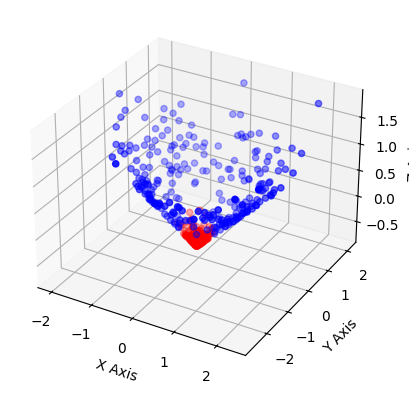

In [55]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Z_p_0.real, Z_p_1.real, Z_p_2.real, c=circles.iloc[:, 2].map({1: 'red', 2: 'blue'}), marker='o')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

plt.show()

This function computes Z' indirectly by computing every column of it. Then calculates the variance along each column and then by the definition, the columns with the highest variances are the top PCs. We can use top 2/3 PCs to plot have an estimated plot of our projection as well.

In [18]:
def get_i_top_PCs(eigenvals, U, K, i):
    variances = []
    n = len(K)
    #computing variances, storing them in a list
    for j in range(n):
        Zpj = compute_Z_prime_c(eigenvals[j], U, K, j)
        variances.append(np.var(Zpj))
    #converting to a numpy.array() to use argsort
    variances = np.array(variances)
    #reversing the order to use the top i indices
    sorted_variance_indices = np.argsort(variances)[::-1]
    top_i_indices = sorted_variance_indices[:i]
    #printing the indices for the top i variances 
    print(top_i_indices)
    #the actual Z'_c s
    top_i_PCs = [compute_Z_prime_c(eigenvals[j], U, K, j) for j in top_i_indices]
    return top_i_PCs

##### Defining the list of degrees we want to create kernels with

In [22]:
degrees = [deg for deg in range(1,20)]
POLY_KERNELS = poly_kernels(degrees)

In [23]:
dlen = len(degrees)
eigvals_poly = [[]]*dlen
U_poly = [[]]*dlen
top_i_PCs = [[]]*dlen
for i in range(dlen):
    eigvals_poly[i], U_poly[i] = np.linalg.eigh(POLY_KERNELS[i])
    top_i_PCs[i] = get_i_top_PCs(eigvals_poly[i], U_poly[i], POLY_KERNELS[i], 3)

[499 498 262]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]


__Interesting Observation:__ while using eigh, in most cases the highest variances belong to the last columns

Now we can plot the projections

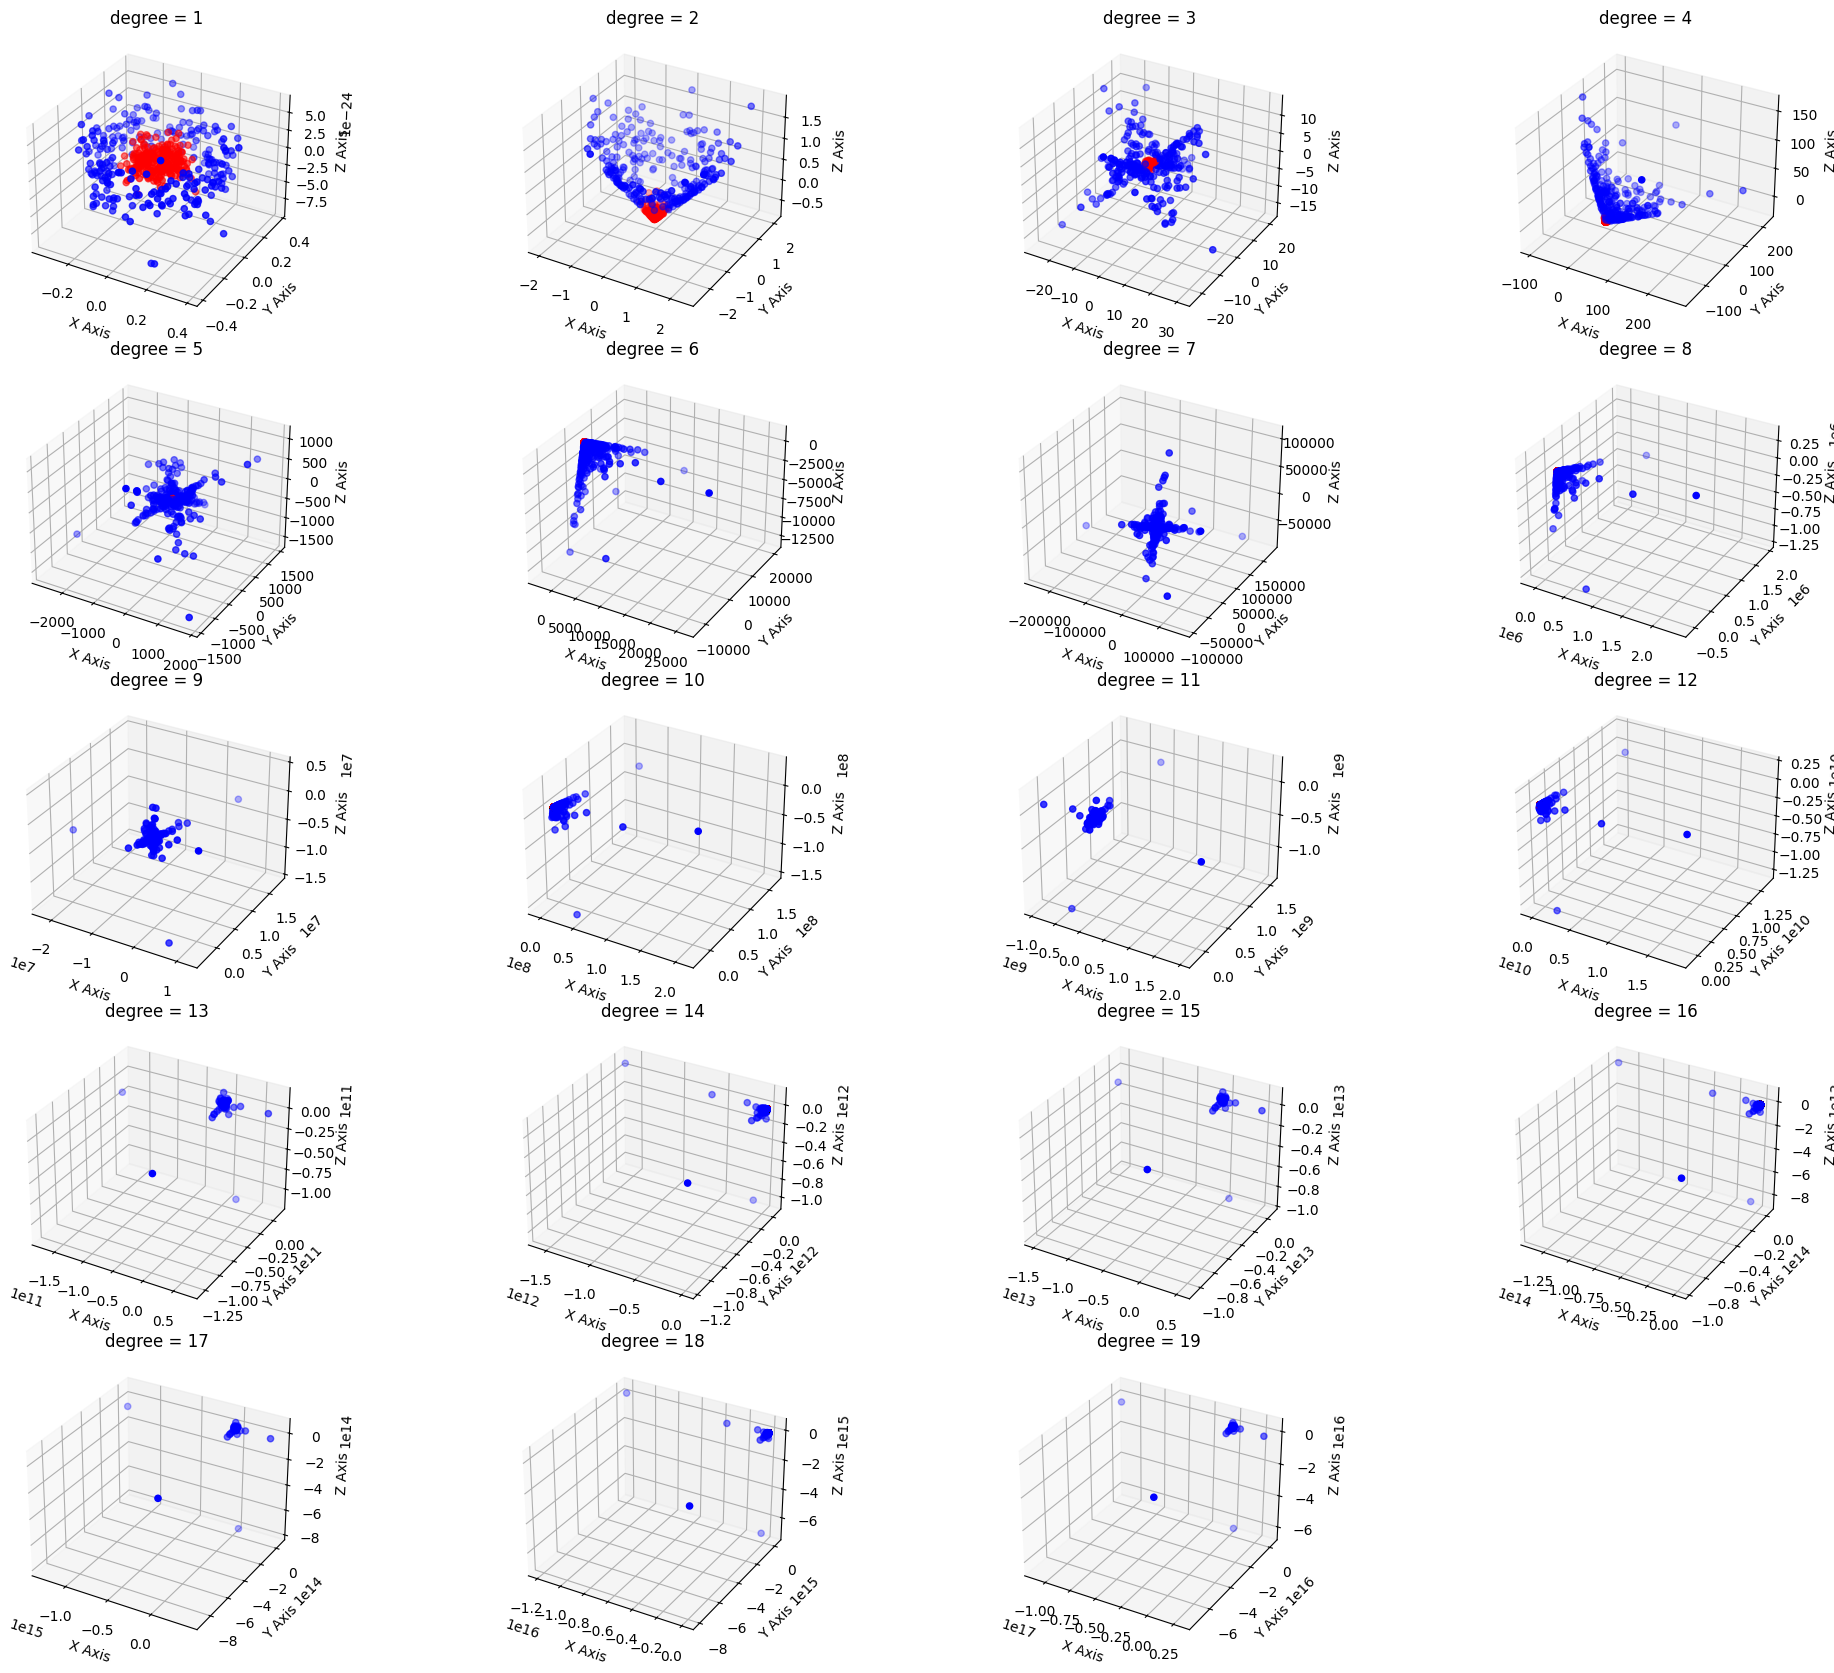

In [57]:
fig = plt.figure(figsize=(20,20))
for i in range(dlen):
    ax =fig.add_subplot(6, 4, i+1, projection='3d')
    ax.set_title(f'degree = {degrees[i]}')
    ax.scatter(top_i_PCs[i][0].real, top_i_PCs[i][1].real, top_i_PCs[i][2].real, c=circles.iloc[:, 2].map({1: 'red', 2: 'blue'}), marker='o')

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')


plt.tight_layout()
plt.show()

##### Defining the set of sigmas we want to create kernels with

In [59]:
sigmas = [x/10 for x in range(1, 80, 4)]
RBF_KERNELS = rbf_kernels(sigmas)

In [60]:
siglen = len(sigmas)
eigvals_rbf = [[]]*siglen
U_rbf = [[]]*siglen
top_i_PCs = [[]]*siglen
for i in range(siglen):
    eigvals_rbf[i], U_rbf[i] = np.linalg.eigh(RBF_KERNELS[i])
    top_i_PCs[i] = get_i_top_PCs(eigvals_rbf[i], U_rbf[i], RBF_KERNELS[i], 3)

[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]
[499 498 497]


We can still see the __interesting observation__

Now we plot our projections

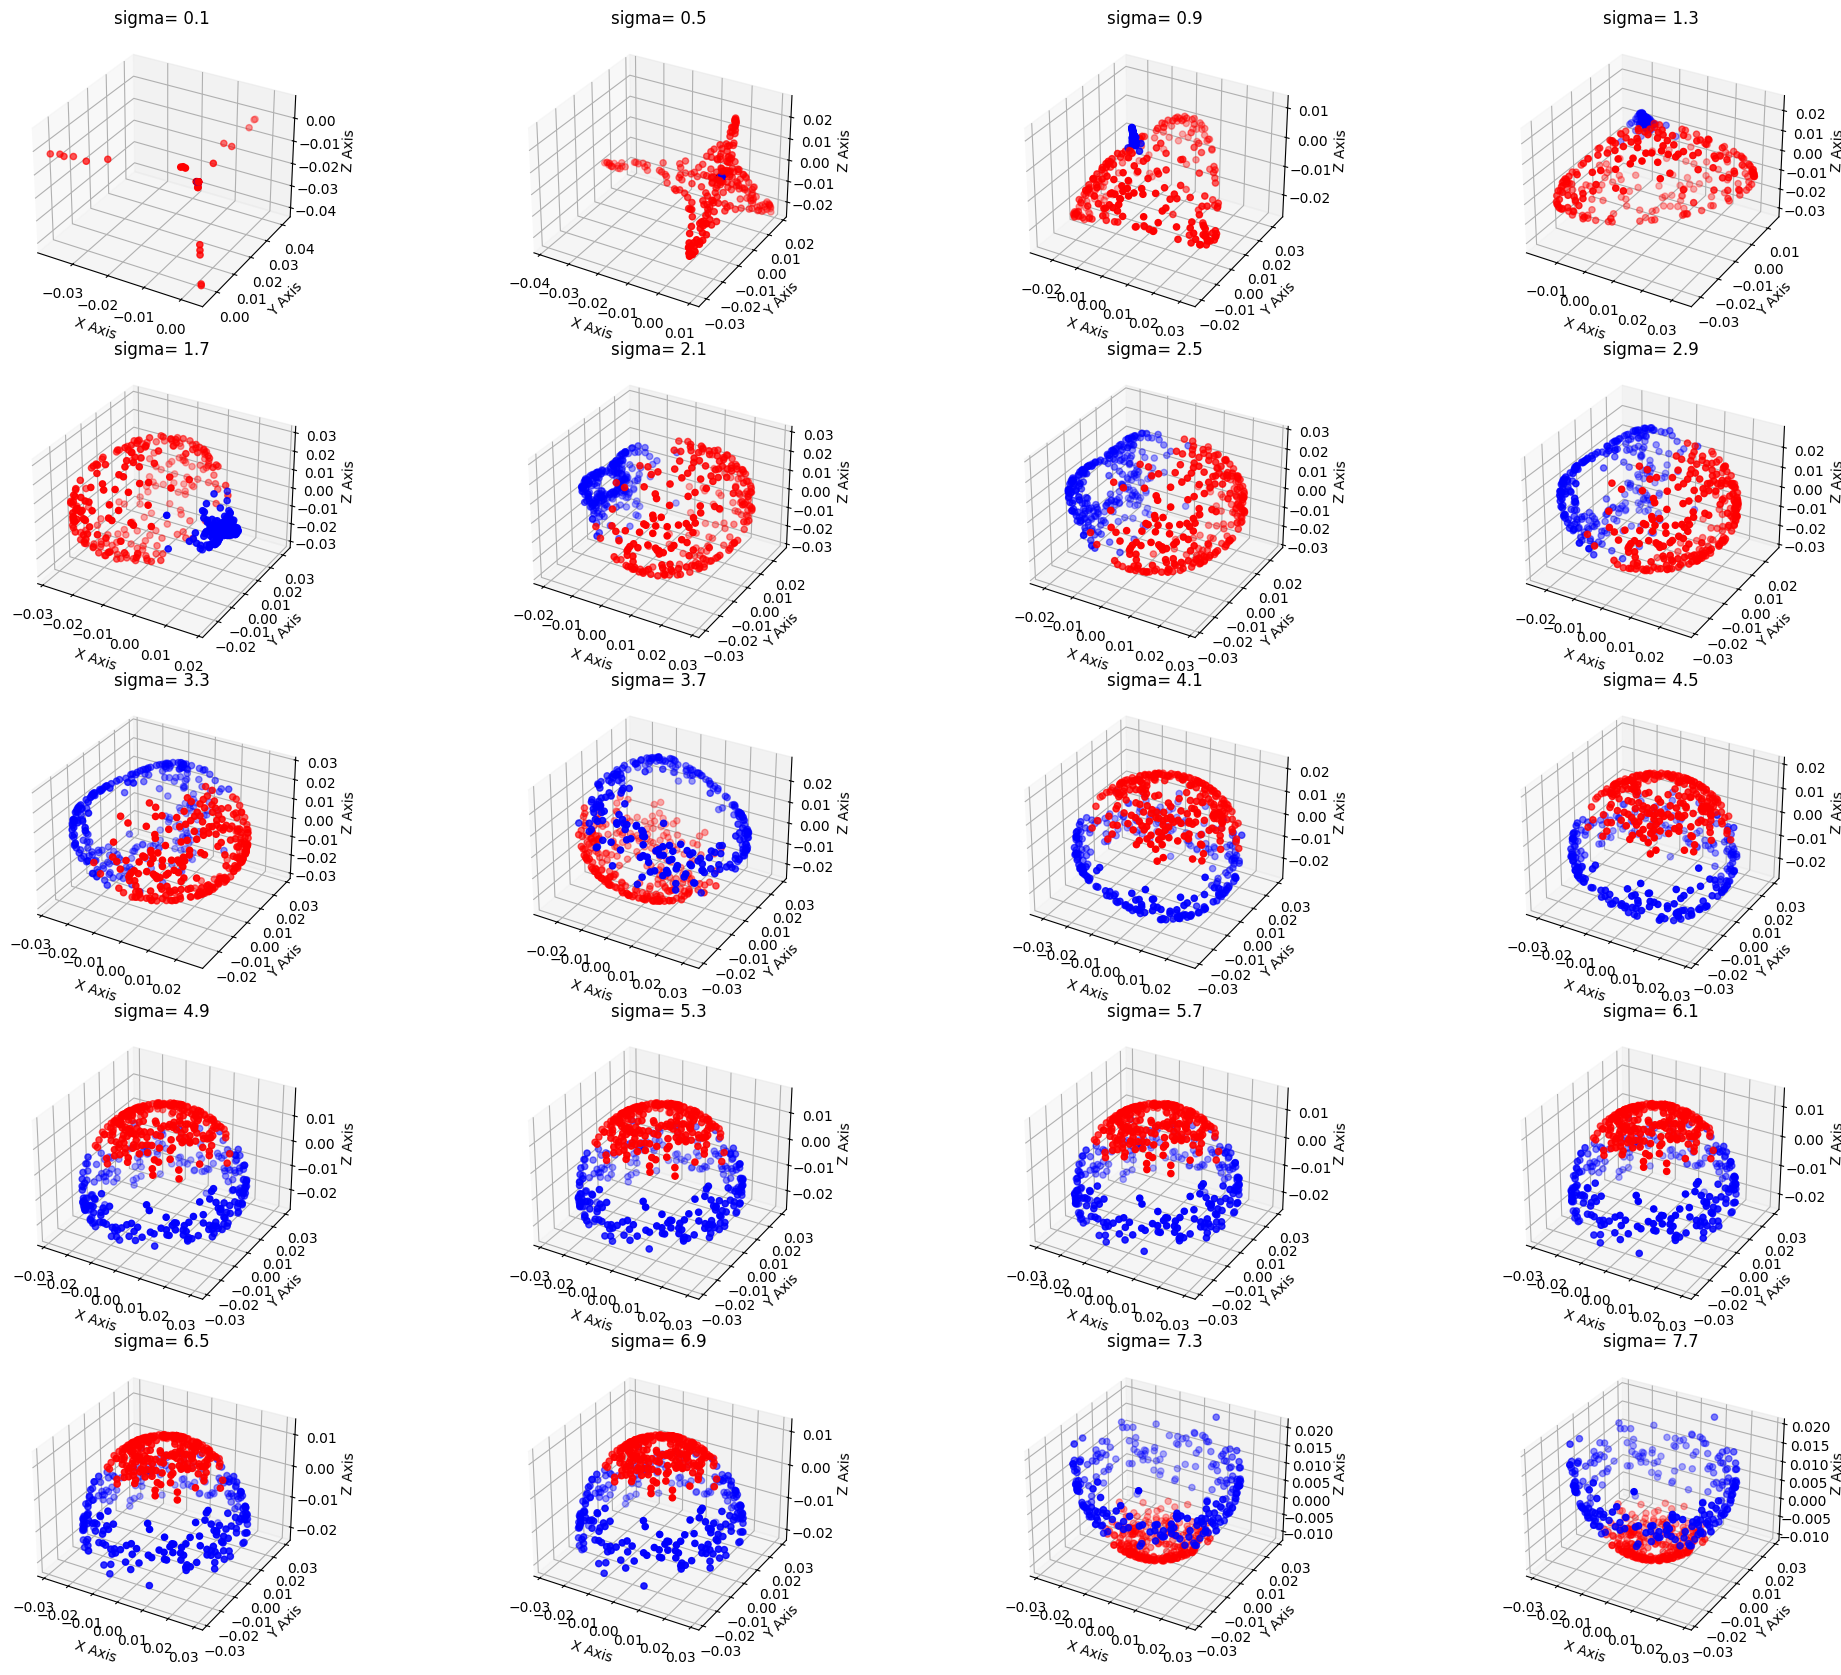

In [61]:
fig = plt.figure(figsize=(20,20))
for i in range(siglen):
    ax =fig.add_subplot(6, 4, i+1, projection='3d')
    ax.set_title(f'sigma= {sigmas[i]}')
    ax.scatter(top_i_PCs[i][0].real, top_i_PCs[i][1].real, top_i_PCs[i][2].real, c=circles.iloc[:, 2].map({1: 'red', 2: 'blue'}), marker='o')

    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')


plt.tight_layout()
plt.show()

# Choice of Kernel
In the few cells above, we have experimented with gaussian (RBF) and polynomial kernels of various sigmas and various degrees, and plotted the approximation of the representation based on their top 3 PCs. However the data seems to be very sensitive to a change of degree in a polynomial kernel, as the higher degrees keep squashing data points together more and more. On the other side, the plotted RBF kernels are separating data in a much more clearer way, which is why we decided to go with __GAUSSIAN (RBF) KERNEL__ for our choice of kernel.

##### At this point we have successfully implemented our method for applying PCA, both with gaussian and polynomial kernels.

# Choice of Parameter
In order to have our data points separable by a single decision stump, we need to choose a sigma where after the projection the minimum of one class is higher than the other class for one of the top PCs. By observing our results in the plots above, we will verify if such condition holds for a sigma between 4 and 7, in the Z axis:

This function gives us a list of sigmas verifyinf the condition, along with the difference between two classes, i.e. the space available for our decision stump

In [62]:
def find_separating_sigma(circles, top_i_PCs, sigmas):
    siglen = len(sigmas)
    result_sigmas = []
    result_diff = []
    for i in range(siglen):
        if sigmas[i] > 4 and sigmas[i] < 7:
            class1 = [top_i_PCs[i][2][j].real for j in range(len(circles)) if circles.iloc[j, 2] == 1]
            class2 = [top_i_PCs[i][2][j].real for j in range(len(circles)) if circles.iloc[j, 2] == 2]
            min_red = min(class1)
            max_blue = max(class2)
            diff = min_red - max_blue
            if diff > 0:
                result_diff.append(diff)
                result_sigmas.append(sigmas[i])
    return result_sigmas, result_diff

Now we take the sigma that gives us the greates margin, as our parameter.

In [63]:
def get_parameter(result_sigmas, result_diff):
    result_diff = np.array(result_diff)
    max_index = np.argmax(result_diff)
    return result_sigmas[max_index]